In [40]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

# use base python(3.9.12)  
# Nvidia 5 year historical data
endpoint_url = "https://financialmodelingprep.com/api/v3/historical-price-full/NVDA?apikey=wc2bbHWhFBL7no45kaUlx2xLHI2z2wv1"

# Fetch data from the endpoint
response = requests.get(endpoint_url)
data = response.json()

# Check if data is fetched successfully
if "historical" in data:
    # Convert data to DataFrame
    df = pd.DataFrame(data["historical"])
    
    
    print("Data for "+data["symbol"]+" For Last 5 years")


    
    # calculate latest Volume  
    latest_volume = df.iloc[0]['volume']
    print("Latest Volume:", latest_volume)

    # Change percentage each year 

    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    yearly_changes = df.groupby('year').agg({'close': lambda x: (x.iloc[-1] - x.iloc[0]) / x.iloc[0] * 100})
    print("Yearly Change Percentage:")
    print(yearly_changes)

    # Change over last 5 years 

    change_over_5_years = (df.iloc[-1]['close'] - df.iloc[0]['close']) / df.iloc[0]['close'] * 100
    print("Change over last 5 years:", change_over_5_years)

    # data analysis / visualization 
    

else:
    print("Failed to fetch data from the API endpoint.")


Data for NVDA For Last 5 years
Latest Volume: 43129744
Yearly Change Percentage:
           close
year            
2019  -22.539521
2020  -54.055917
2021  -55.411241
2022  106.110579
2023  -71.093655
2024  -46.690867
Change over last 5 years: -94.95661605206072


## Libraries

In [38]:
import requests
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

## Fetching Data

In [39]:
endpoint_url = "https://financialmodelingprep.com/api/v3/historical-price-full/NVDA?apikey=wc2bbHWhFBL7no45kaUlx2xLHI2z2wv1"
response = requests.get(endpoint_url)
data = response.json()

## data preprocessing


In [40]:
if "historical" in data:
    # Convert data to DataFrame
    df = pd.DataFrame(data["historical"])
    
    # Preprocessing
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    
else:
    print("Failed to fetch data from the API endpoint.")

## Feature selection



In [41]:

features = ['open', 'high', 'low', 'close', 'volume']
target = ['close']

# extract targhet and features from dataframe
X = df[features]
y = df[target]

F = df[features] 
F.head()
# F.describe()

,open,high,low,close,volume
date,,,,,
2024-03-28,900.00,913.00,891.93,903.56,43129744
2024-03-27,931.12,932.40,891.23,902.50,58606723
2024-03-26,958.51,963.75,925.02,925.61,51364758
2024-03-25,939.41,967.66,935.10,950.02,55213608
2024-03-22,911.41,947.78,908.34,942.89,58671936


## Training (70%) and Testing (30%) 

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


## Normalizing 

In [43]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Time series Dataset

In [44]:

time_steps = 10
def create_dataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

## Number of cycles

## Creating Training and Testing dataset

In [45]:
X_train, y_train = create_dataset(X_train_scaled, y_train.values, time_steps)
X_test, y_test = create_dataset(X_test_scaled, y_test.values, time_steps)

## Building LSTM Model

In [46]:
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Training the model 

In [47]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/50
49/49 [==============================] - 2s 14ms/step - loss: 72685.0469 - val_loss: 78451.3750
Epoch 2/50
49/49 [==============================] - 0s 3ms/step - loss: 68826.4219 - val_loss: 76291.0625
Epoch 3/50
49/49 [==============================] - 0s 3ms/step - loss: 67142.3750 - val_loss: 74796.2891
Epoch 4/50
49/49 [==============================] - 0s 3ms/step - loss: 65765.0703 - val_loss: 73450.3359
Epoch 5/50
49/49 [==============================] - 0s 3ms/step - loss: 64494.8711 - val_loss: 72186.2109
Epoch 6/50
49/49 [==============================] - 0s 3ms/step - loss: 63292.2773 - val_loss: 70980.3594
Epoch 7/50
49/49 [==============================] - 0s 3ms/step - loss: 62140.9844 - val_loss: 69821.3281
Epoch 8/50
49/49 [==============================] - 0s 3ms/step - loss: 61032.4297 - val_loss: 68702.5078
Epoch 9/50
49/49 [==============================] - 0s 3ms/step - loss: 59961.3633 - val_loss: 67619.6953
Epoch 10/50
49/49 [==========================

## Training and Validation loss

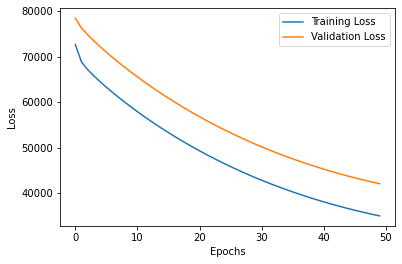

In [48]:
# plotting 
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [49]:
# Make predictions on the test data
y_pred = model.predict(X_test)


12/12 [==============================] - 0s 1ms/step


# Prediction vs Actual

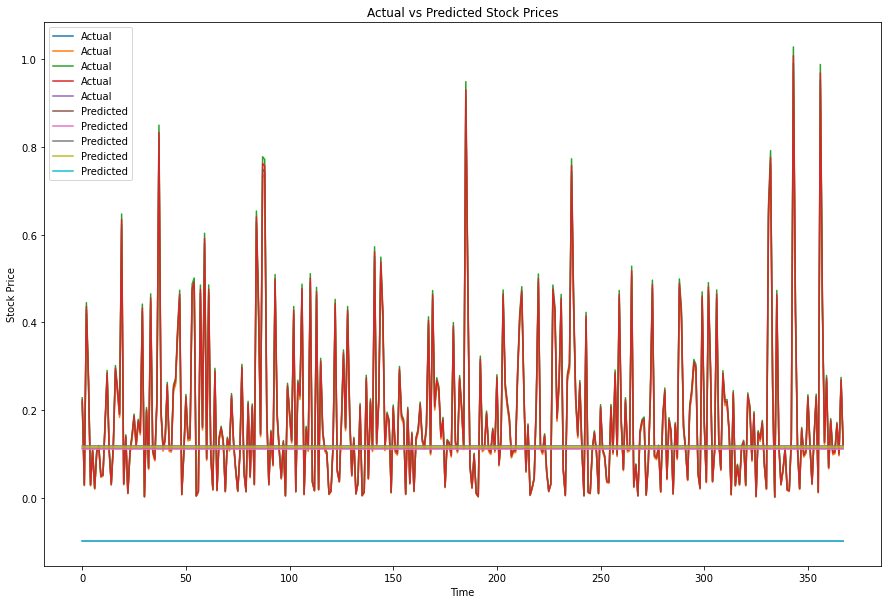

In [69]:
# Broadcast scaler parameters to match the shape of the input data
min_broadcasted = scaler.min_.reshape(1, -1)
scale_broadcasted = scaler.scale_.reshape(1, -1)

# Apply inverse transformation manually
y_test_inverse = y_test_reshaped * scale_broadcasted + min_broadcasted
y_pred_inverse = y_pred_reshaped * scale_broadcasted + min_broadcasted

# Plotting
plt.figure(figsize=(15, 10))
plt.plot(y_test_inverse, label='Actual')
plt.plot(y_pred_inverse, label='Predicted')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
